## Overview

This notebook explores the use of the regime shift detection algorithm presented by [Rodionov (2004)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2004GL019448), and which was previously used by [Penderson et al. (2013)](https://journals.ametsoc.org/view/journals/clim/26/4/jcli-d-11-00723.1.xml?tab_body=fulltext-display) in the Delware River Basin. 

The study by Penderson et al. (2013) claimed that a strong pluvial (wet) regime dominated the upper DRB from 1970-2011 (time of study).  This notebook attempts to replicate the analysis and extend it the present, using observed streamflow in the Delaware River at Port Jarvis, NY (USGS-0143400).  





In [1]:
import numpy as np
import pandas as pd

# Import the algorithm
from rodionov import rodionov_regimes
from regime_plots import plot_regime_changes_with_alt_params, plot_single_regime_changes

# Load flow
Q = pd.read_csv('usgs_01434000_daily_cms.csv', sep=',', index_col=0, parse_dates=True)
Q.head(1)

,USGS-01434000
1904-10-01,155.742656


In [2]:
def remove_seasonality(df):
    """Standardizes by month mean and std

    Args:
        df (pd.DataFrame): Df containing flows and DateTime index. Must be daily.

    Returns:
        pd.DataFrame: Df containing de-seasoned flows and DateTime index.
    """
    # Extract the month and day from the datetime index
    df['month'] = df.index.month
    df['day'] = df.index.day

    # Group the data by month and day and calculate the average streamflow for each combination
    monthly_average = df.groupby(['month', 'day']).mean()

    # Merge the monthly average data back to the original dataframe based on month and day
    merged_df = pd.merge(df, monthly_average, on=['month', 'day'], how='left', suffixes=('', '_avg'))

    # Calculate the deseasonalized streamflow by subtracting the average streamflow for each day
    df_deseasonalized = merged_df.drop(['month', 'day'], axis=1)
    df_deseasonalized = df_deseasonalized.subtract(df_deseasonalized.filter(regex='_avg$').values)

    # Remove the temporary columns
    df_deseasonalized = df_deseasonalized.drop(df_deseasonalized.filter(regex='_avg$').columns, axis=1)
    df_deseasonalized.index = pd.to_datetime(df.index)
    return df_deseasonalized

In [3]:
# Standardize to emphazise anomolous flows
std_Q = remove_seasonality(np.log(Q))

# Groupby year and take mean or sum (algorithm is not sensitive to magnitude)
Z_annual = std_Q.groupby(std_Q.index.year).mean()

In [4]:
### Rodionov algorithm
# Parameters
l, p = 10, 0.005

# run
shift_indices, rsi_values = rodionov_regimes(Z_annual.values.flatten(), l, p)

print(f'Regime changes detected in years: {[Z_annual.index[0]+ i for i in shift_indices]}')

Regime changes detected in years: [2003]


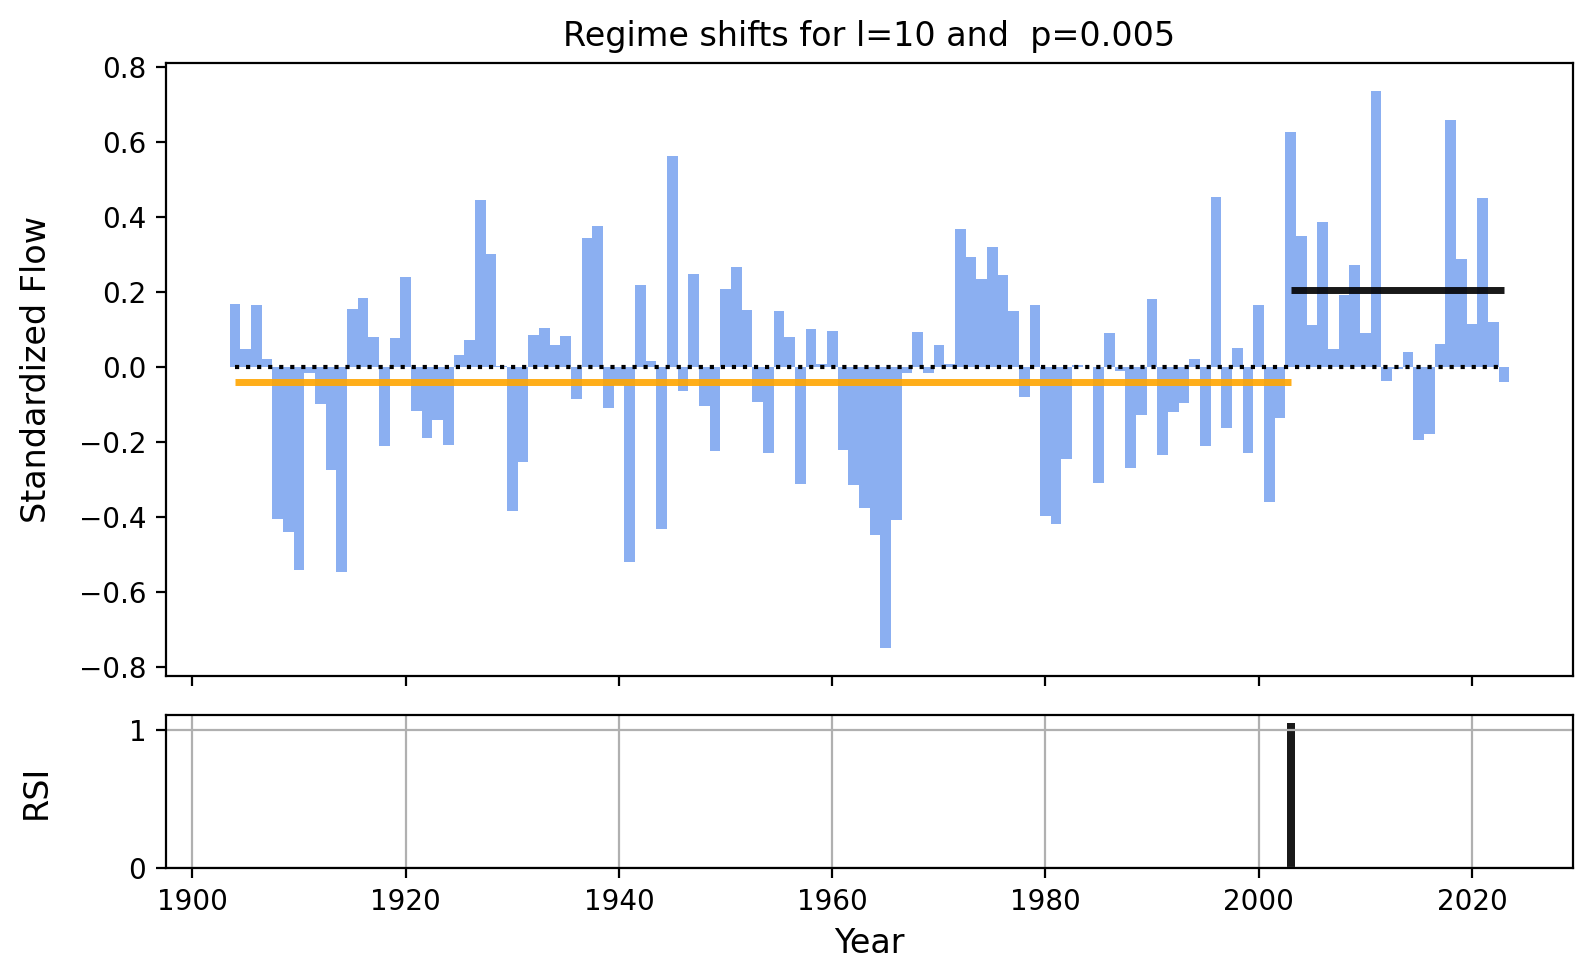

In [5]:
plot_single_regime_changes(Z_annual, shift_indices=shift_indices, rsi_values=rsi_values, 
                           l=l, p=p)

## Alternative parameterizations

The regime shifts found using the Rodionov algorithm is sensitive to the `l` and parameterization, and it may be that Pederson et al. (2013) used a different parameterization (I didn't see it detailed in the publication).  Although, in hydrology is often very difficult to decide on a definitive timescale for hydrologic processes that are highly unpredictable, like wet/dry regimes.  

Rather than specifying a single assumed minimum regime length, I re-ran the Rodionov algorithm using every regime length between 5 and 35.

The figure below shows all of the different regimes determined to be significant across the range of different regime lengths.  I also added a measure of Found Frequency (lower row) which indicates how often a specific year contained a significant regime shift across the 30 instances of the search.


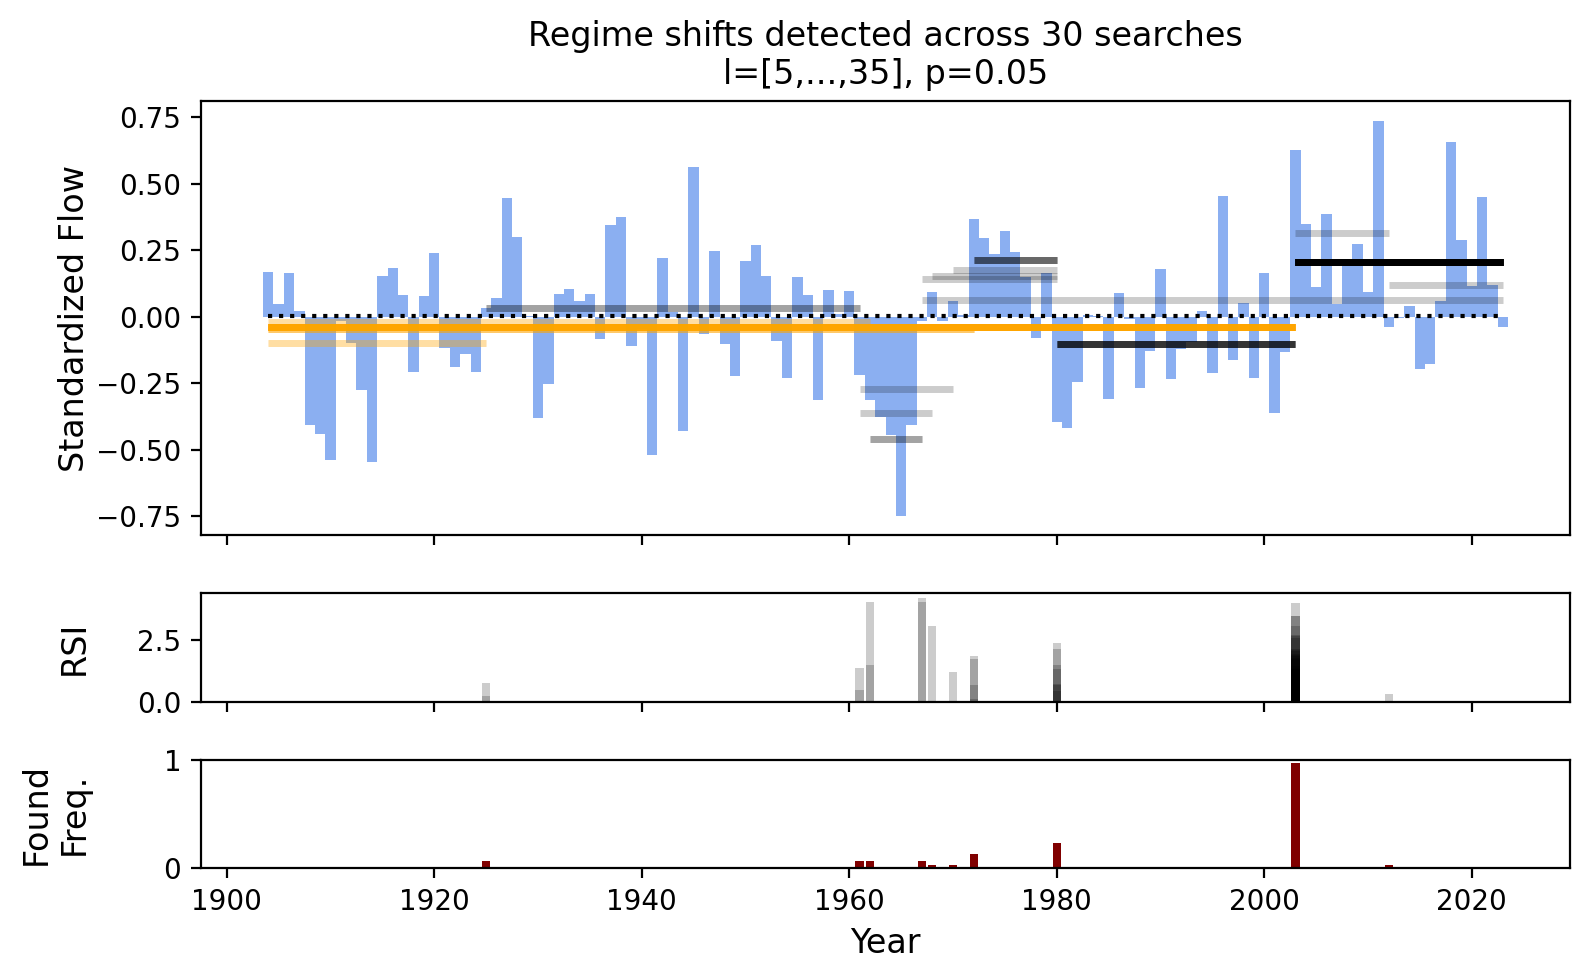

In [6]:
# Run the algorithm using a range of different L values
plot_regime_changes_with_alt_params(Z_annual,
                                    l_min=5, l_max=35, p= 0.05)